In [15]:
import numpy as np
import math as mt
import plotly.graph_objects as go


# Явная схема "Крест"

In [28]:
N = 100
M = 50
J = 250

tau = 1/J
h_x = 1/(N-0.5)
h_y = 1/(M-0.5)


In [29]:
x = np.linspace(-h_x/2, 1, N+1)
y = np.linspace(-h_y/2, 1, M+1)
t = np.linspace(0,1,J+1)
w = np.zeros((N+1,M+1,J+1))

In [30]:
for n in range(N+1):
    for m in range(M+1):
        w[n,m,0] = 5*mt.cos(mt.pi*x[n]/2)*mt.cos(3*mt.pi*y[m]/2)
        w[n,m,1] = w[n,m,0] + tau**2*(x[n]+y[m] - 25*mt.pi**2/4 * mt.cos(mt.pi*x[n]/2)*mt.cos(3*mt.pi*y[m]/2))


In [31]:
for j in range(1,J):
    for n in range(1,N):
        for m in range(1,M):
            w[n,m,j+1] = 2*w[n,m,j] - w[n,m,j-1] + tau**2 * 2*(x[n]+y[m]) +(
                        tau/h_x)**2 * (w[n+1,m,j] - 2*w[n,m,j] + w[n-1,m,j]) + (
                        tau/h_y)**2 * (w[n,m+1,j] - 2*w[n,m,j] + w[n,m-1,j])
    w[0,:,j+1] = w[1,:,j+1] - h_x*t[j+1]**2
    w[:,0,j+1] = w[:,1,j+1] - h_y*t[j+1]**2
    w[N,:,j+1] = t[j+1]**2*(1+y[:])
    w[:,M,j+1] = t[j+1]**2*(1+x[:])


In [32]:
real = np.zeros((N+1,M+1,J+1))
err = np.zeros((N+1,M+1,J+1))
max = 0
min  = 0
for n in range(N+1):
    for m in range(M+1):
        for j in range(J+1):
            real[n,m,j] = t[j]**2*(x[n]+y[m]) + 5*mt.cos(mt.sqrt(5/2)*mt.pi*t[j])*mt.cos(mt.pi*x[n]/2)*mt.cos(3*mt.pi*y[m]/2)
            err[n,m,j] = real[n,m,j] - w[n,m,j]
            if err[n,m,j]>max:
                max = err[n,m,j]
            if err[n,m,j]<min:
                min  = err[n,m,j]
print(max,min)

0.007768435494629022 -0.007768435494574677


In [35]:
fig = go.Figure(data=[go.Surface(z=w[:,:,50], x=y, y=x)])
fig.update_layout(title='Численное решение при t =50*tau ', autosize = True,height = 800,scene = dict(
                     xaxis_title='y', yaxis_title='x', zaxis_title='W'),)
fig.show()

fig1 = go.Figure(data=[go.Surface(z=real[:,:,50], x=y, y=x)])
fig1.update_layout(title='Аналитическое решение при t =50*tau ', autosize = True,height = 800,scene = dict(
                     xaxis_title='y', yaxis_title='x', zaxis_title='real'),)


fig2 = go.Figure(data=[go.Surface(z=err[:,:,50], x=y, y=x)])
fig2.update_layout(title='Ошибка при t =50*tau ', autosize = True,height = 800,scene = dict(
                     xaxis_title='y', yaxis_title='x', zaxis_title='err'),)


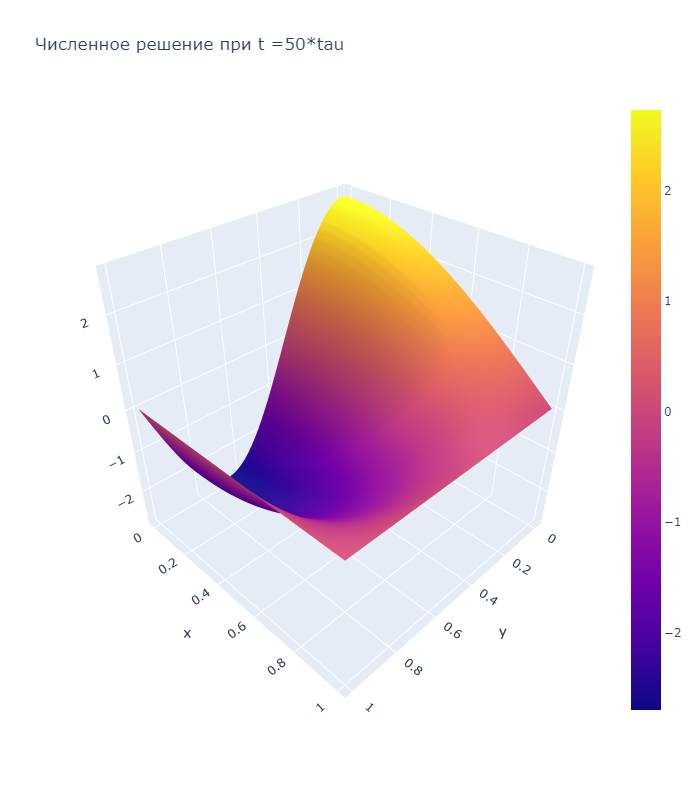

In [36]:
fig1.show()

In [37]:
fig2.show()

# Эволюционно - факторизованная схема

In [22]:
N = 100
M = 100
J = 100
sigma = 0.25

tau = 1/J
h_x = 1/(N-0.5)
h_y = 1/(M-0.5)


In [23]:
x = np.linspace(-h_x/2, 1, N+1)
y = np.linspace(-h_y/2, 1, M+1)
t = np.linspace(0,1,J+1)
w = np.zeros((N+1,M+1,J+1))

In [24]:
for n in range(N+1):
    for m in range(M+1):
        w[n,m,0] = 5*mt.cos(mt.pi*x[n]/2)*mt.cos(3*mt.pi*y[m]/2)
        w[n,m,1] = w[n,m,0] + tau**2*(x[n]+y[m] - 25*mt.pi**2/4 * mt.cos(mt.pi*x[n]/2)*mt.cos(3*mt.pi*y[m]/2))


In [25]:
for j in range(1,J):
    prom = np.zeros((N+1,M+1))
    for m in range(1,M):
        
        alpha = np.zeros(N+1)
        beta = np.zeros(N+1)
        f = np.zeros(N+1)
        
        c0,b0,f0 = 1,1,-2*h_x
        aN, cN, fN = 0,1, 2*h_x*(1+y[m]) #- (tau/h_y)**2 * (y[m+1]-2*y[m]+y[m-1]))
        a,b,c = sigma*(tau/h_x)**2, sigma*(tau/h_x)**2, (1+2*sigma*(tau/h_x)**2)
        
        alpha[0] = b0/c0
        beta[0] = f0/c0
        
        for i in range(1, N):
            
            f[i] = ((w[i+1,m,j] - 2*w[i,m,j] +w[i-1,m,j])/h_x**2 + (
                    w[i,m+1,j] - 2*w[i,m,j] + w[i,m-1,j])/h_y**2 + 2*(x[i] +y[m]))
            alpha[i] = b/(c - alpha[i-1]*a)
            beta[i] = (f[i]+beta[i-1]*a)/(c - a*alpha[i-1])
        
        beta[N] = (fN +beta[N-1]*aN)/(cN - aN*alpha[N-1])
        prom[N, m] = beta[N]
        
        for i in range(N-1, -1, -1):
            prom[i, m] = alpha[i]*prom[i+1, m] + beta[i]
        
    for n in range(1,N):
        
        alpha = np.zeros(M+1)
        beta = np.zeros(M+1)
        f = np.zeros(M+1)
        c0,b0,f0 = 1,1,-h_y*t[j+1]**2
        aN, cN, fN = 0,1,t[j]**2 *(1+x[n])
        a,b,c = sigma*(tau/h_y)**2, sigma*(tau/h_y)**2, (1+2*sigma*(tau/h_y)**2)
        
        alpha[0] = b0/c0
        beta[0] = f0/c0
        
        for m in range(1, M):
            
            f[m] = tau**2 * prom[n,m] +2*w[n,m,j] - w[n,m,j-1]+sigma*(tau/h_y)**2 *(
                    -2*(w[n,m-1,j] - 2*w[n,m,j]+w[n,m+1,j]) + w[n,m+1,j-1] - 2*w[n,m,j-1] + w[n,m-1,j-1])
            alpha[m] = b/(c - alpha[m-1]*a)
            beta[m] = (f[m]+beta[m-1]*a)/(c - a*alpha[m-1])
        
        beta[M] = (fN +beta[M-1]*aN)/(cN - aN*alpha[M-1])
        w[n, M,j+1] = beta[M]
        
        for i in range(M-1, -1, -1):
            w[n, i,j+1] = alpha[i]*w[n, i+1,j+1] + beta[i]
        
    w[0,:,j+1] = w[1,:,j+1] - h_x*t[j+1]**2
    w[N,:,j+1] = (1+y[:])*t[j]**2

In [26]:
real = np.zeros((N+1,M+1,J+1))
err = np.zeros((N+1,M+1,J+1))
max = 0
min  = 0
for n in range(N+1):
    for m in range(M+1):
        for j in range(J+1):
            real[n,m,j] = t[j]**2*(x[n]+y[m]) + 5*mt.cos(mt.sqrt(5/2)*mt.pi*t[j])*mt.cos(mt.pi*x[n]/2)*mt.cos(3*mt.pi*y[m]/2)
            err[n,m,j] = real[n,m,j] - w[n,m,j]
            if err[n,m,j]>max:
                max = err[n,m,j]
            if err[n,m,j]<min:
                min  = err[n,m,j]
print(max,min)

0.03980000000000006 -0.0025566468139150977


In [27]:
fig3 = go.Figure(data=[go.Surface(z=w[:,:,30], x=y, y=x)])
fig3.update_layout(title='Численное решение при t =30*tau ', autosize = True,height = 800,scene = dict(
                     xaxis_title='y', yaxis_title='x', zaxis_title='W'),)
fig3.show()

fig4 = go.Figure(data=[go.Surface(z=err[:,:,30], x=y, y=x)])
fig4.update_layout(title='Численное решение при t =30*tau ', autosize = True,height = 800,scene = dict(
                     xaxis_title='y', yaxis_title='x', zaxis_title='err'),)
fig4.show()